In [32]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
import numpy as np
import IPython.display as ipd
module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load models

In [2]:
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule

state_dict_path = '/nfs/students/summer-term-2020/project-4/SAVED_MODELS/SpectrogramCNN/optuna_90.5.p'
loaded_dict = torch.load(state_dict_path)
loaded_dict['hparams']['batch_size'] = 5
model = SpectrogramCNNPLModule(loaded_dict['hparams'])
model.model.load_state_dict(loaded_dict['state_dict'])
model = model.cuda()
model = model.eval()

# Load Data

In [3]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [4]:
datasetHandler.load(model, 'validation')

Loading cached validation data of dataset 0 from /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_48k/


# Load Overlay data

In [5]:
import pickle

In [6]:
overlay_data_path = "/nfs/students/summer-term-2020/project-4/data/interpolation_data/data_48k/interpolation_data_downsampled.p"
overlay_data = pickle.load(open(overlay_data_path, "rb"))

In [7]:
classes = set([data['category'] for data in overlay_data])

In [8]:
overlay_dataset = {}
for data in overlay_data:
    overlay_dataset.setdefault(data['category'], []).append(data)

In [9]:
del overlay_dataset['Alarm']
classes.remove("Alarm")

# Attacks

In [10]:
fixed_epsilon = 0.002

## Functional Interpolation (perceptible)

In [20]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack
import torch.nn.functional as F

attack_results = {}

for overlay_class in classes:
    
    overlay_success_rate = 0 
    for overlay_sample in overlay_dataset[overlay_class]:
        overlay_sample = {'meta': overlay_sample}
        audio = torch.tensor(overlay_sample['meta']['data'][0])
        overlay_sample['audio'] = F.pad(audio, (0, 481489 - len(audio)), mode='constant', value=0)
        
        
        attack_parameters = {'overlay_sound': overlay_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': fixed_epsilon, 'num_iter': 1, 'upper2': 1,
                         }
        fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=False)
        fva.attack()
        
        attack_results.setdefault(overlay_class,[]).append(fva)

100%|██████████| 338/338 [00:16<00:00, 20.23it/s]


100%|██████████| 338/338 [00:16<00:00, 20.24it/s]


In [56]:
fine_grained_categories = {}

for top_level_category in attack_results:
    for sample in attack_results[top_level_category]:
        for category in sample.attack_parameters['overlay_sound']['meta']['label_names']:
            fine_grained_categories.setdefault(category, []).append(sample.getSuccessRate())

In [60]:
np.mean([len(x) for x in fine_grained_categories.values()])

6.4145569620253164

In [35]:
for category in fine_grained_categories:
    fine_grained_categories[category] = np.mean(fine_grained_categories[category])

In [46]:
len(fine_grained_categories.keys())

316

In [43]:
for key, value in sorted(fine_grained_categories.items(), key=lambda item: item[1], reverse=True)[:20]:
    print("%s: %s" % (key, value))

Propeller, airscrew: 0.886482939632546
Shout: 0.8402230971128608
Music for children: 0.7979002624671916
Tap: 0.7926509186351706
Humming: 0.7703412073490814
Video game music: 0.7664041994750657
Quack: 0.765748031496063
Happy music: 0.7460629921259843
Chatter: 0.7450787401574803
Techno: 0.7381889763779528
Children playing: 0.7335958005249344
Carnatic music: 0.7322834645669292
Soundtrack music: 0.7283464566929134
Groan: 0.7198162729658792
Car passing by: 0.7125984251968503
Clapping: 0.7106299212598425
Yodeling: 0.7066929133858267
Cello: 0.7001312335958005
Double bass: 0.7001312335958005
Drill: 0.6968503937007874


In [42]:
for key, value in sorted(fine_grained_categories.items(), key=lambda item: item[1], reverse=False)[:10]:
    print("%s: %s" % (key, value))

Fusillade: 0.3484251968503937
Maraca: 0.35761154855643046
Caw: 0.36220472440944884
Sound effect: 0.3733595800524934
Eruption: 0.37860892388451445
Wail, moan: 0.37926509186351703
Rock music: 0.38353018372703407
Gargling: 0.38976377952755903
Jet engine: 0.3937007874015748
Didgeridoo: 0.39960629921259844


In [55]:
torch.save(attack_results, "/nfs/students/summer-term-2020/project-4/yan/100_top_level_classes_average.dict.pt")

# Samples

In [ ]:
for sample in overlay_data:
    if 'Propeller, airscrew' in sample['label_names']:
        print(sample)
        ipd.display(ipd.Audio(sample['data'][0],    rate=sample['data'][1], normalize=False))

# Visualization

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [73]:
result = attack_results
result = {re.sub(r" ?\([^)]+\)", "", entry): [result[entry]*100] for entry in sorted(result, key = lambda x: result[x], reverse=True)}

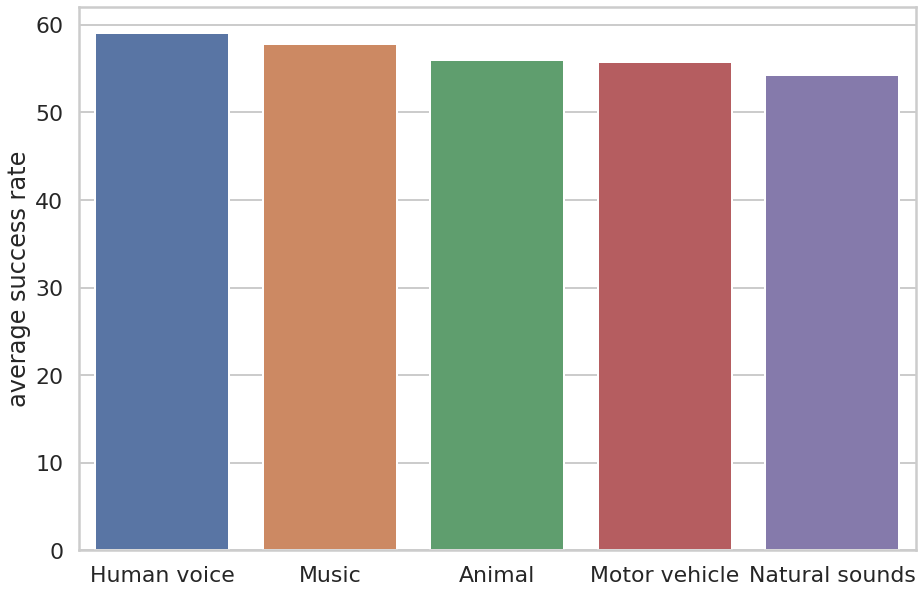

In [74]:
df = pd.DataFrame.from_dict(result)

sns.set()
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(15,10))
plt.ylabel("average success rate")
ax = sns.barplot(data=df)